<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/BADATON/%EC%83%9D%ED%99%9C%EC%9D%B4%EB%8F%99%20%EC%8B%9C%EA%B3%84%EC%97%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
!pip install pandas_datareader
import pandas as pd
import pandas_datareader.data as pdr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
from pmdarima.arima import auto_arima
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import numpy as np

# Preprocessing

In [4]:
df = pd.read_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동_통합_데이터.csv")
df

,귀가시간대,대상연월,요일,출발 시군구 코드,도착 시군구 코드,성별,나이대,이동유형,이동인구수
0,00:00:00,2022-12-01,금,11010,11110,F,20대,EH,225.18
1,00:00:00,2022-12-01,금,11010,11110,F,20대,HH,1.50
2,00:00:00,2022-12-01,금,11010,11110,F,20대,WH,175.66
3,00:00:00,2022-12-01,금,11010,11110,F,30대,EH,91.37
4,00:00:00,2022-12-01,금,11010,11110,F,30대,WH,79.61
...,...,...,...,...,...,...,...,...,...
1937819,23:00:00,2023-03-01,화,39000,11240,M,30대,EH,10.97
1937820,23:00:00,2023-03-01,화,39000,11240,M,40대,EH,31.03
1937821,23:00:00,2023-03-01,화,39000,11240,M,50대,EH,3.28
1937822,23:00:00,2023-03-01,화,39000,11240,M,60대,EH,3.49


In [6]:
df['대상연월'] = pd.to_datetime(df['대상연월'], format='%Y-%m-%d')
#출발 시군구 코드에서 2, 3으로 시작하는 행 제거
df = df[~df['출발 시군구 코드'].astype(str).str.startswith(('2', '3'))]
df

,귀가시간대,대상연월,요일,출발 시군구 코드,도착 시군구 코드,성별,나이대,이동유형,이동인구수
0,00:00:00,2022-12-01,금,11010,11110,F,20대,EH,225.18
1,00:00:00,2022-12-01,금,11010,11110,F,20대,HH,1.50
2,00:00:00,2022-12-01,금,11010,11110,F,20대,WH,175.66
3,00:00:00,2022-12-01,금,11010,11110,F,30대,EH,91.37
4,00:00:00,2022-12-01,금,11010,11110,F,30대,WH,79.61
...,...,...,...,...,...,...,...,...,...
1933870,23:00:00,2023-03-01,화,11250,11240,M,60대,HH,3.52
1933871,23:00:00,2023-03-01,화,11250,11240,M,60대,WH,137.66
1933872,23:00:00,2023-03-01,화,11250,11240,M,70대,EH,72.09
1933873,23:00:00,2023-03-01,화,11250,11240,M,70대,WH,42.98


In [7]:
df = pd.DataFrame(df.groupby(['나이대', '대상연월', '귀가시간대']).sum()['이동인구수']); df

이동인구수
나이대 대상연월       귀가시간대              
20대 2022-12-01 00:00:00  445273.25
               01:00:00  235751.75
               02:00:00  164441.48
               03:00:00  116185.75
               04:00:00   76873.03
...                            ...
80대 2023-03-01 19:00:00  166280.64
               20:00:00  107829.33
               21:00:00   75378.33
               22:00:00   49640.66
               23:00:00   27541.85

[308 rows x 1 columns]

In [8]:
df = df.reset_index(level=0); df

나이대      이동인구수
대상연월       귀가시간대                   
2022-12-01 00:00:00  20대  445273.25
           01:00:00  20대  235751.75
           02:00:00  20대  164441.48
           03:00:00  20대  116185.75
           04:00:00  20대   76873.03
...                  ...        ...
2023-03-01 19:00:00  80대  166280.64
           20:00:00  80대  107829.33
           21:00:00  80대   75378.33
           22:00:00  80대   49640.66
           23:00:00  80대   27541.85

[308 rows x 2 columns]

In [9]:
df_20대 = df[df['나이대']=='20대']
df_30대 = df[df['나이대']=='30대']
df_40대 = df[df['나이대']=='40대']
df_50대 = df[df['나이대']=='50대']
df_60대 = df[df['나이대']=='60대']
df_70대 = df[df['나이대']=='70대']
df_80대 = df[df['나이대']=='80대']

In [10]:
df_20대

나이대      이동인구수
대상연월       귀가시간대                   
2022-12-01 00:00:00  20대  445273.25
           01:00:00  20대  235751.75
           02:00:00  20대  164441.48
           03:00:00  20대  116185.75
           04:00:00  20대   76873.03
           18:00:00  20대  722673.23
           19:00:00  20대  796317.78
           20:00:00  20대  680582.12
           21:00:00  20대  715631.89
           22:00:00  20대  791476.01
           23:00:00  20대  627041.15
2023-01-01 00:00:00  20대  400934.32
           01:00:00  20대  217839.98
           02:00:00  20대  146785.79
           03:00:00  20대  100751.42
           04:00:00  20대   70770.31
           18:00:00  20대  694203.71
           19:00:00  20대  780799.36
           20:00:00  20대  664021.56
           21:00:00  20대  698433.90
           22:00:00  20대  750596.15
           23:00:00  20대  572645.44
2023-02-01 00:00:00  20대  401380.86
           01:00:00  20대  205350.44
           02:00:00  20대  137985.66
           03:00:00  20대   92214.71
           04:00:00  20대   65909.99
           18:00:00  20대  680812.91
           19:00:00  20대  773243.05
           20:00:00  20대  663833.03
           21:00:00  20대  663833.03
           22:00:00  20대  578025.60
           23:00:00  20대  578025.60
2023-03-01 00:00:00  20대  473520.88
           01:00:00  20대  242239.73
           02:00:00  20대  157694.24
           03:00:00  20대  104937.47
           04:00:00  20대   72790.25
           18:00:00  20대  821580.56
           19:00:00  20대  905663.38
           20:00:00  20대  780586.88
           21:00:00  20대  819112.10
           22:00:00  20대  899710.20
           23:00:00  20대  687323.88

# 데이터의 분포 살펴보기

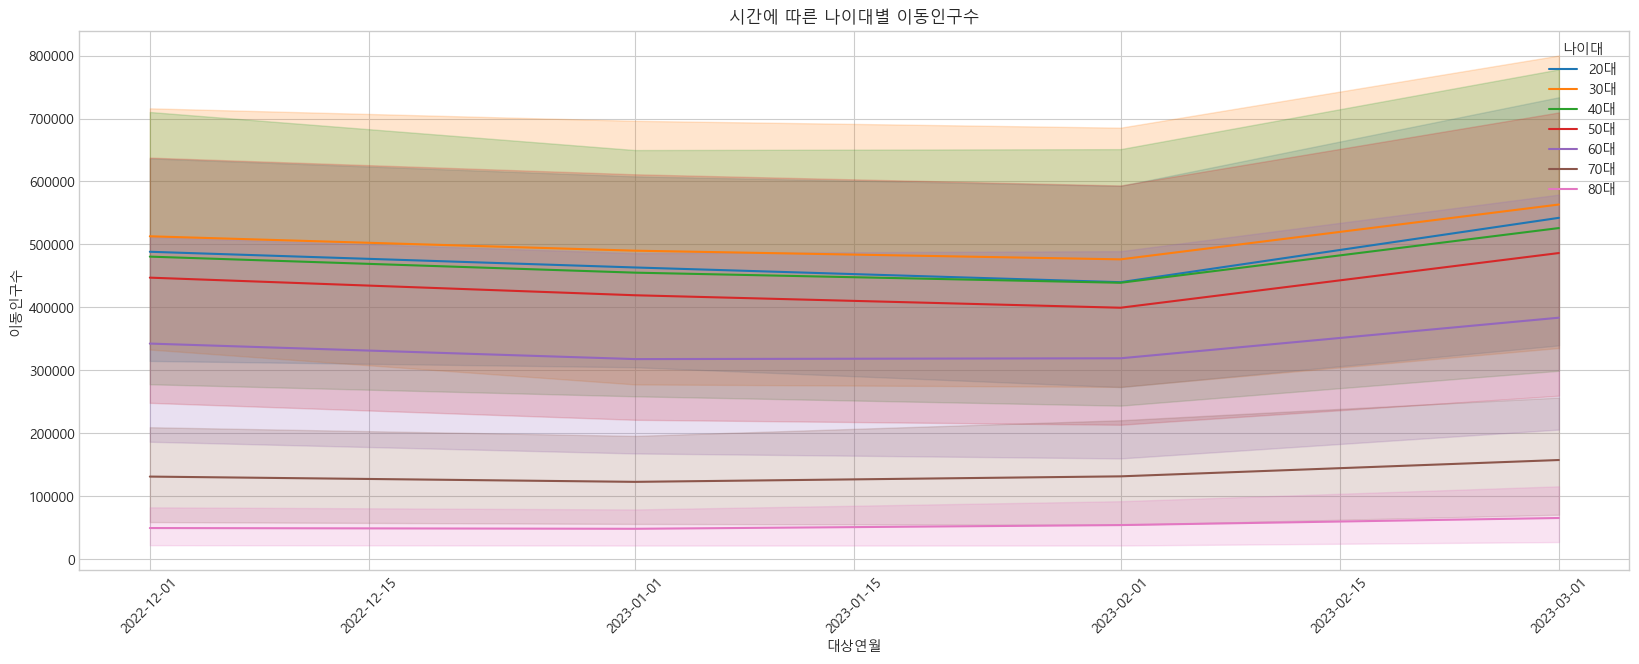

In [ ]:
plt.figure(figsize=(20, 7))
ax = sns.lineplot(x='대상연월', y='이동인구수', hue='나이대', data=df)
plt.xticks(rotation=45)
plt.title('시간에 따른 나이대별 이동인구수')
plt.show()

# stationary 검정

In [11]:
def adfuller_test(df):
        result = adfuller(df)

        labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

        for label, value in zip(labels, result):
            print(label + ' : ' + str(value) )

        if result[1] <= 0.05:
            print('정상성', '\n')
        else:
            print('비정상성', '\n')

In [14]:
adfuller_test(df_20대['이동인구수'])
adfuller_test(df_30대['이동인구수'])
adfuller_test(df_40대['이동인구수'])
adfuller_test(df_50대['이동인구수'])
adfuller_test(df_60대['이동인구수'])
adfuller_test(df_70대['이동인구수'])
adfuller_test(df_80대['이동인구수'])

ADF Test Statistic : 1.319571510174648
p-value : 0.9967163011798401
#Lags Used : 10
Number of Observations Used : 33
비정상성 

ADF Test Statistic : 1.0953034162941764
p-value : 0.9951763391549954
#Lags Used : 10
Number of Observations Used : 33
비정상성 

ADF Test Statistic : 0.5711688592996393
p-value : 0.986883006852194
#Lags Used : 10
Number of Observations Used : 33
비정상성 

ADF Test Statistic : 0.27944453417126003
p-value : 0.9763815081027095
#Lags Used : 10
Number of Observations Used : 33
비정상성 

ADF Test Statistic : 0.9440660432485073
p-value : 0.993639277709804
#Lags Used : 10
Number of Observations Used : 33
비정상성 

ADF Test Statistic : 1.3809683494373517
p-value : 0.9970259457034003
#Lags Used : 10
Number of Observations Used : 33
비정상성 

ADF Test Statistic : 1.6159029895028252
p-value : 0.997904510611465
#Lags Used : 10
Number of Observations Used : 33
비정상성 



In [15]:
#1차 차분
df_20대_diff = df_20대['이동인구수'].diff().dropna()
adfuller_test(df_20대_diff)

df_30대_diff = df_30대['이동인구수'].diff().dropna()
adfuller_test(df_30대_diff)

df_40대_diff = df_40대['이동인구수'].diff().dropna()
adfuller_test(df_40대_diff)

df_50대_diff = df_50대['이동인구수'].diff().dropna()
adfuller_test(df_50대_diff)

df_60대_diff = df_60대['이동인구수'].diff().dropna()
adfuller_test(df_60대_diff)

df_70대_diff = df_70대['이동인구수'].diff().dropna()
adfuller_test(df_70대_diff)

df_80대_diff = df_80대['이동인구수'].diff().dropna()
adfuller_test(df_80대_diff)

ADF Test Statistic : -1.8507333354922941
p-value : 0.3555804654201471
#Lags Used : 10
Number of Observations Used : 32
비정상성 

ADF Test Statistic : -16.491057572821678
p-value : 2.1921668454197043e-29
#Lags Used : 9
Number of Observations Used : 33
정상성 

ADF Test Statistic : -15.914927673046442
p-value : 8.044737481484845e-29
#Lags Used : 9
Number of Observations Used : 33
정상성 

ADF Test Statistic : -3.088323179031276
p-value : 0.02742948077050123
#Lags Used : 10
Number of Observations Used : 32
정상성 

ADF Test Statistic : -18.449184956039936
p-value : 2.155127581922941e-30
#Lags Used : 9
Number of Observations Used : 33
정상성 

ADF Test Statistic : -23.61228779269754
p-value : 0.0
#Lags Used : 9
Number of Observations Used : 33
정상성 

ADF Test Statistic : -27.668781823545476
p-value : 0.0
#Lags Used : 9
Number of Observations Used : 33
정상성 



In [16]:
#20대 이동인구수 2차 차분
df_20대_diff2 = df_20대_diff.diff().dropna()
adfuller_test(df_20대_diff2)

ADF Test Statistic : -6.002740437138566
p-value : 1.6425812737141262e-07
#Lags Used : 10
Number of Observations Used : 31
정상성 



# 연령대별 데이터 구분

In [17]:
selected_data_20s = df_20대[['이동인구수']]
selected_data_30s = df_30대[['이동인구수']]
selected_data_40s = df_40대[['이동인구수']]
selected_data_50s = df_50대[['이동인구수']]
selected_data_60s = df_60대[['이동인구수']]
selected_data_70s = df_70대[['이동인구수']]
selected_data_80s = df_80대[['이동인구수']]

#각 연령대별 데이터를 딕셔너리로 저장
age_data = {
    '20대': selected_data_20s,
    '30대': selected_data_30s,
    '40대': selected_data_40s,
    '50대': selected_data_50s,
    '60대': selected_data_60s,
    '70대': selected_data_70s,
    '80대': selected_data_80s
}

In [19]:
selected_data_20s

이동인구수
대상연월       귀가시간대              
2022-12-01 00:00:00  445273.25
           01:00:00  235751.75
           02:00:00  164441.48
           03:00:00  116185.75
           04:00:00   76873.03
           18:00:00  722673.23
           19:00:00  796317.78
           20:00:00  680582.12
           21:00:00  715631.89
           22:00:00  791476.01
           23:00:00  627041.15
2023-01-01 00:00:00  400934.32
           01:00:00  217839.98
           02:00:00  146785.79
           03:00:00  100751.42
           04:00:00   70770.31
           18:00:00  694203.71
           19:00:00  780799.36
           20:00:00  664021.56
           21:00:00  698433.90
           22:00:00  750596.15
           23:00:00  572645.44
2023-02-01 00:00:00  401380.86
           01:00:00  205350.44
           02:00:00  137985.66
           03:00:00   92214.71
           04:00:00   65909.99
           18:00:00  680812.91
           19:00:00  773243.05
           20:00:00  663833.03
           21:00:00  663833.03
           22:00:00  578025.60
           23:00:00  578025.60
2023-03-01 00:00:00  473520.88
           01:00:00  242239.73
           02:00:00  157694.24
           03:00:00  104937.47
           04:00:00   72790.25
           18:00:00  821580.56
           19:00:00  905663.38
           20:00:00  780586.88
           21:00:00  819112.10
           22:00:00  899710.20
           23:00:00  687323.88

In [20]:
age_data

{'20대':                          이동인구수
 대상연월       귀가시간대              
 2022-12-01 00:00:00  445273.25
            01:00:00  235751.75
            02:00:00  164441.48
            03:00:00  116185.75
            04:00:00   76873.03
            18:00:00  722673.23
            19:00:00  796317.78
            20:00:00  680582.12
            21:00:00  715631.89
            22:00:00  791476.01
            23:00:00  627041.15
 2023-01-01 00:00:00  400934.32
            01:00:00  217839.98
            02:00:00  146785.79
            03:00:00  100751.42
            04:00:00   70770.31
            18:00:00  694203.71
            19:00:00  780799.36
            20:00:00  664021.56
            21:00:00  698433.90
            22:00:00  750596.15
            23:00:00  572645.44
 2023-02-01 00:00:00  401380.86
            01:00:00  205350.44
            02:00:00  137985.66
            03:00:00   92214.71
            04:00:00   65909.99
            18:00:00  680812.91
            19:00:00  773243.05
 

# ACF

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


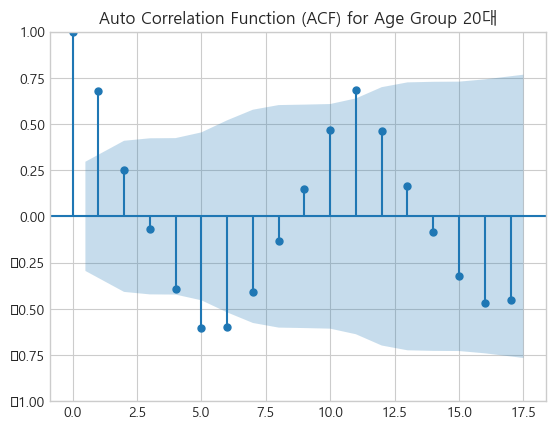

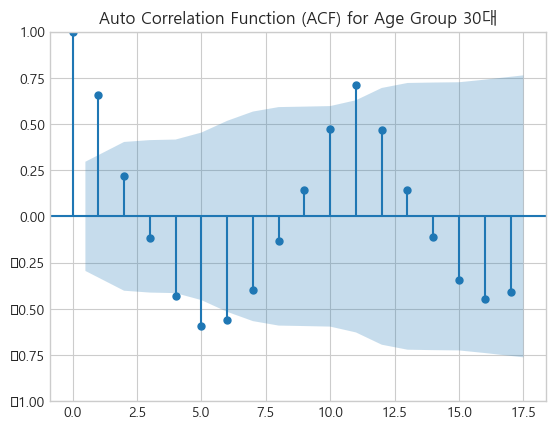

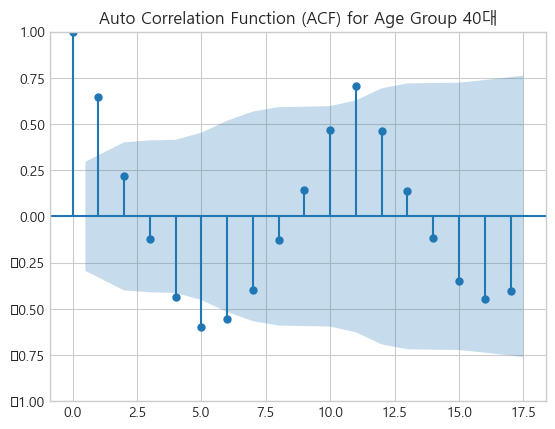

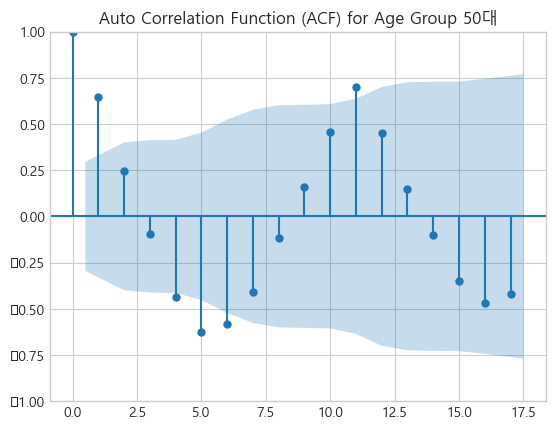

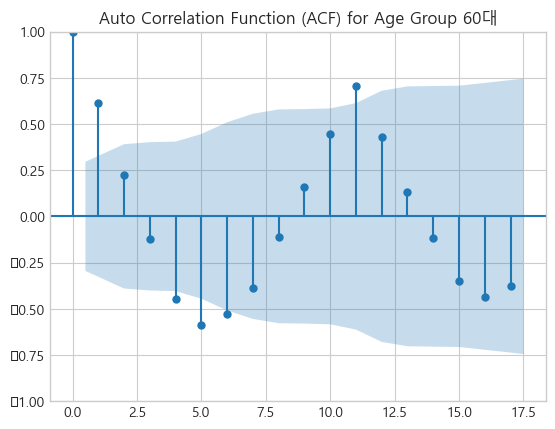

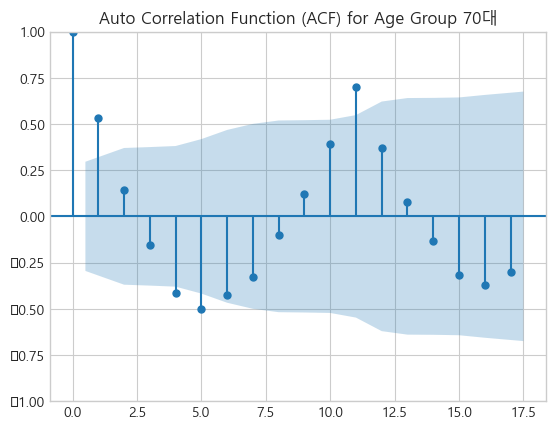

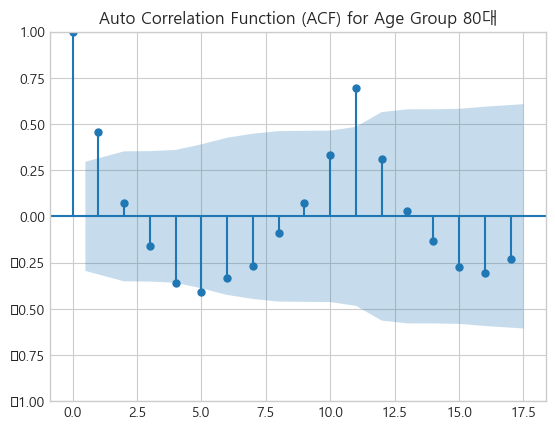

In [ ]:
for age_group, selected_data in age_data.items():
    ax = sm.graphics.tsa.plot_acf(selected_data)
    plt.title(f'Auto Correlation Function (ACF) for Age Group {age_group}')
    plt.show()

# ARIMA

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA(3, 1, 3) model for Age Group 20대 >> AIC: 1180.189941027617
                               SARIMAX Results                                
Dep. Variable:                  이동인구수   No. Observations:                   44
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -583.095
Date:                Tue, 15 Aug 2023   AIC                           1180.190
Time:                        14:50:19   BIC                           1192.518
Sample:                             0   HQIC                          1184.736
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7305      0.314      2.327      0.020       0.115       1.346
ar.L2          0.4553      0.347      1.312      0.190      -

C:\Users\82107\AppData\Local\Temp\ipykernel_25472\128104527.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


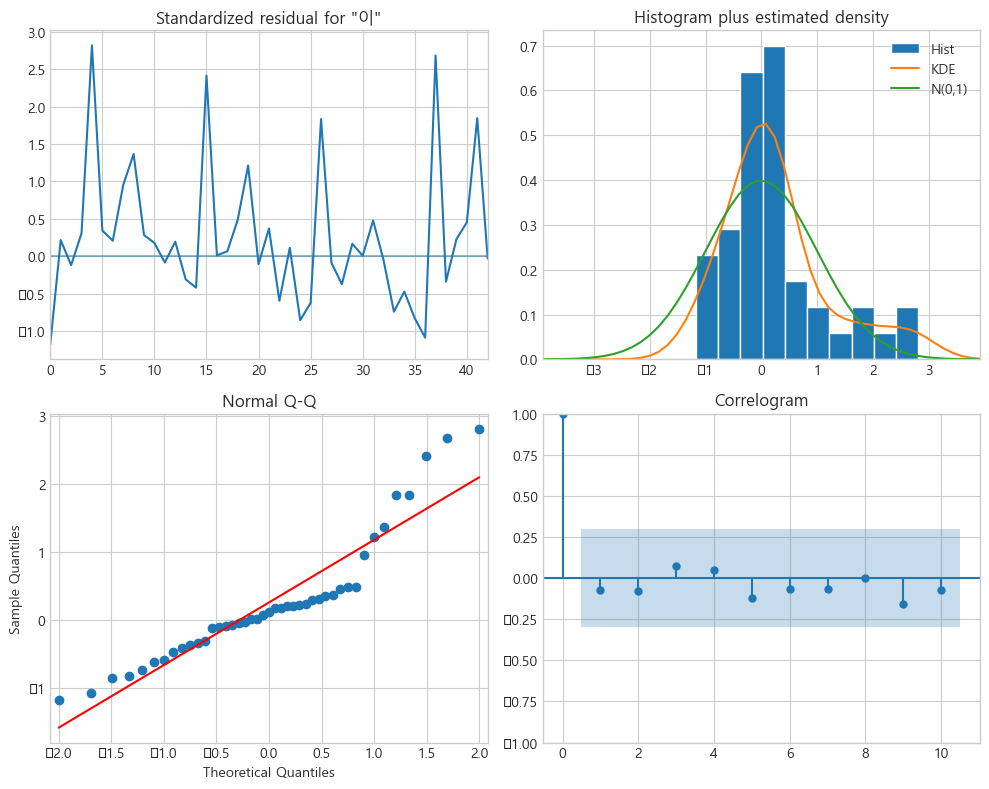

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA(3, 1, 3) model for Age Group 30대 >> AIC: 1201.0599691134537
                               SARIMAX Results                                
Dep. Variable:                  이동인구수   No. Observations:                   44
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -593.530
Date:                Tue, 15 Aug 2023   AIC                           1201.060
Time:                        14:50:24   BIC                           1213.388
Sample:                             0   HQIC                          1205.606
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6378      0.364      1.754      0.079      -0.075       1.350
ar.L2          0.5274      0.367      1.438      0.150      

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


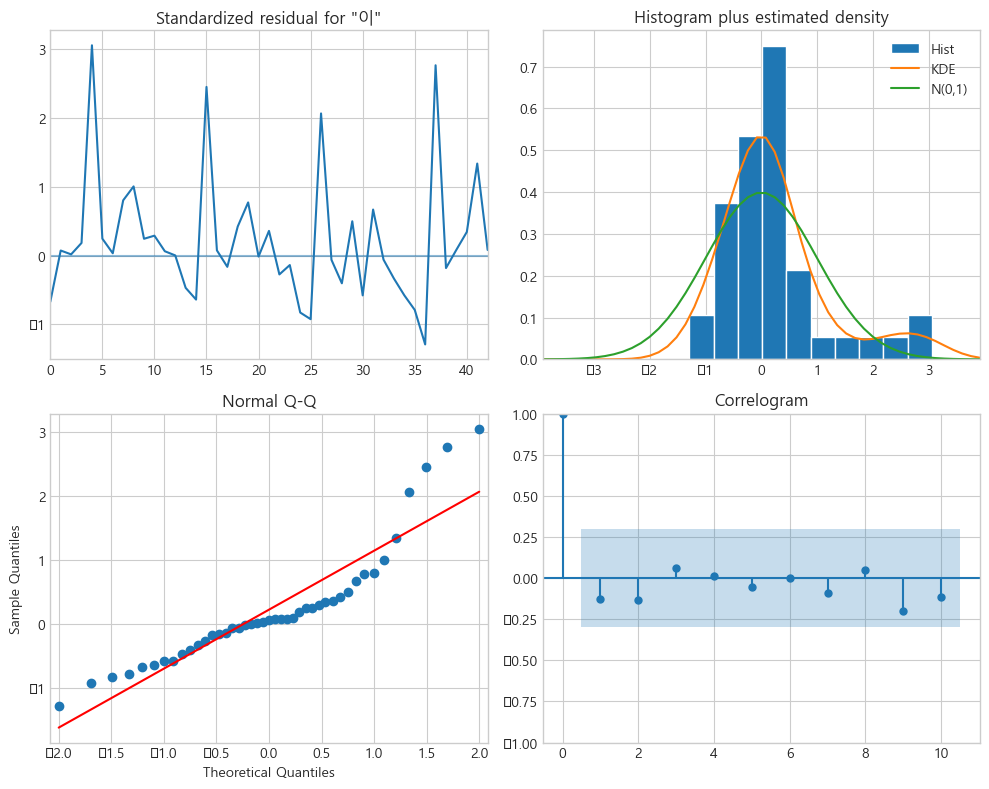

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA(2, 1, 2) model for Age Group 40대 >> AIC: 1200.8799378884016
                               SARIMAX Results                                
Dep. Variable:                  이동인구수   No. Observations:                   44
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -595.440
Date:                Tue, 15 Aug 2023   AIC                           1200.880
Time:                        14:50:28   BIC                           1209.686
Sample:                             0   HQIC                          1204.127
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5204      0.255      5.964      0.000       1.021       2.020
ar.L2         -0.8058      0.331     -2.434      0.015      

C:\Users\82107\AppData\Local\Temp\ipykernel_25472\128104527.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


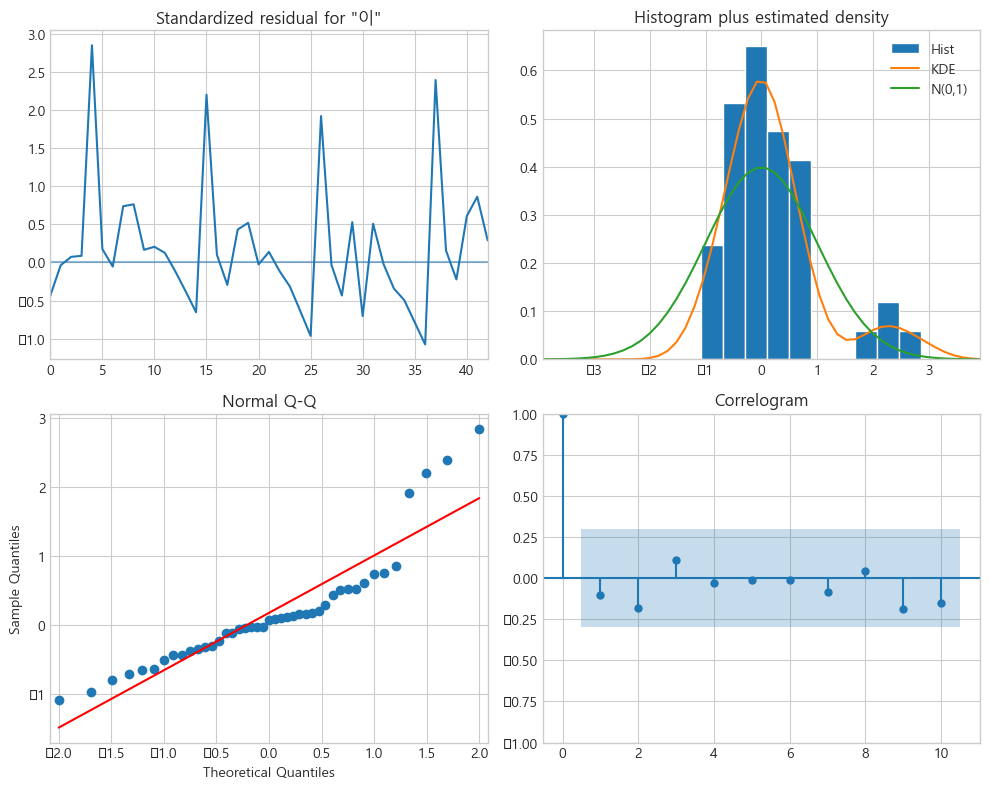

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA(3, 1, 3) model for Age Group 50대 >> AIC: 1197.9510951514696
                               SARIMAX Results                                
Dep. Variable:                  이동인구수   No. Observations:                   44
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -591.976
Date:                Tue, 15 Aug 2023   AIC                           1197.951
Time:                        14:50:33   BIC                           1210.279
Sample:                             0   HQIC                          1202.497
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6133      0.325      1.887      0.059      -0.024       1.250
ar.L2          0.5707      0.330      1.730      0.084      

C:\Users\82107\AppData\Local\Temp\ipykernel_25472\128104527.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


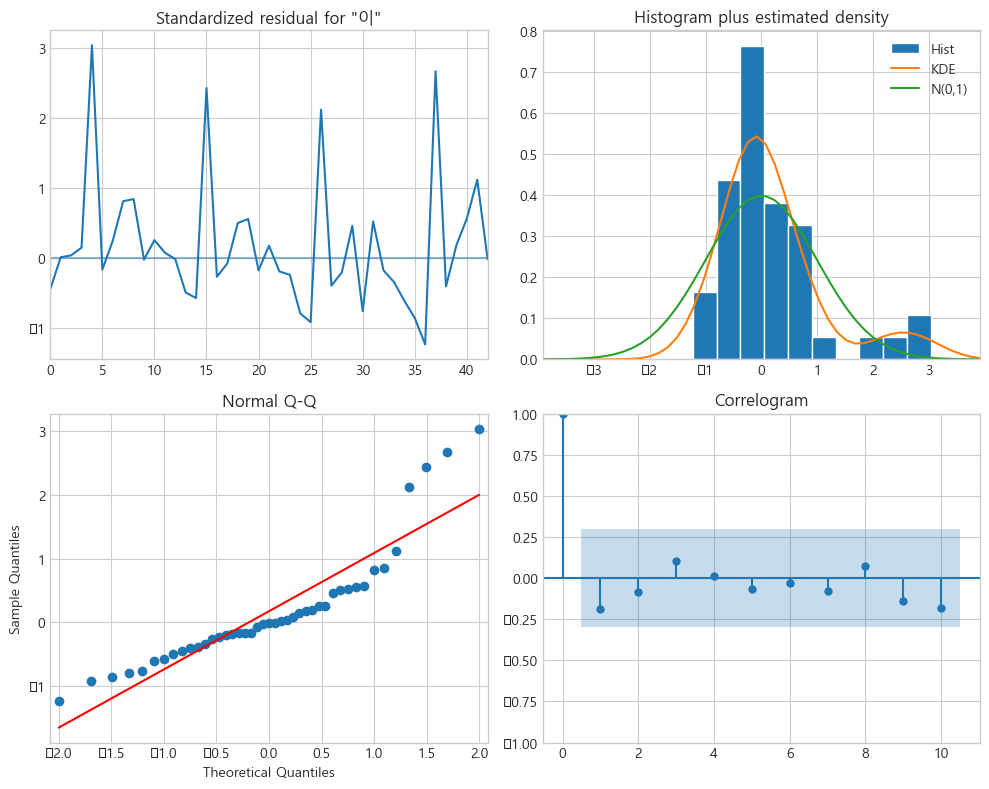

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA(3, 1, 3) model for Age Group 60대 >> AIC: 1187.2424977454093
                               SARIMAX Results                                
Dep. Variable:                  이동인구수   No. Observations:                   44
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -586.621
Date:                Tue, 15 Aug 2023   AIC                           1187.242
Time:                        14:50:38   BIC                           1199.571
Sample:                             0   HQIC                          1191.789
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5635      0.302      1.867      0.062      -0.028       1.155
ar.L2          0.6000      0.265      2.260      0.024      

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


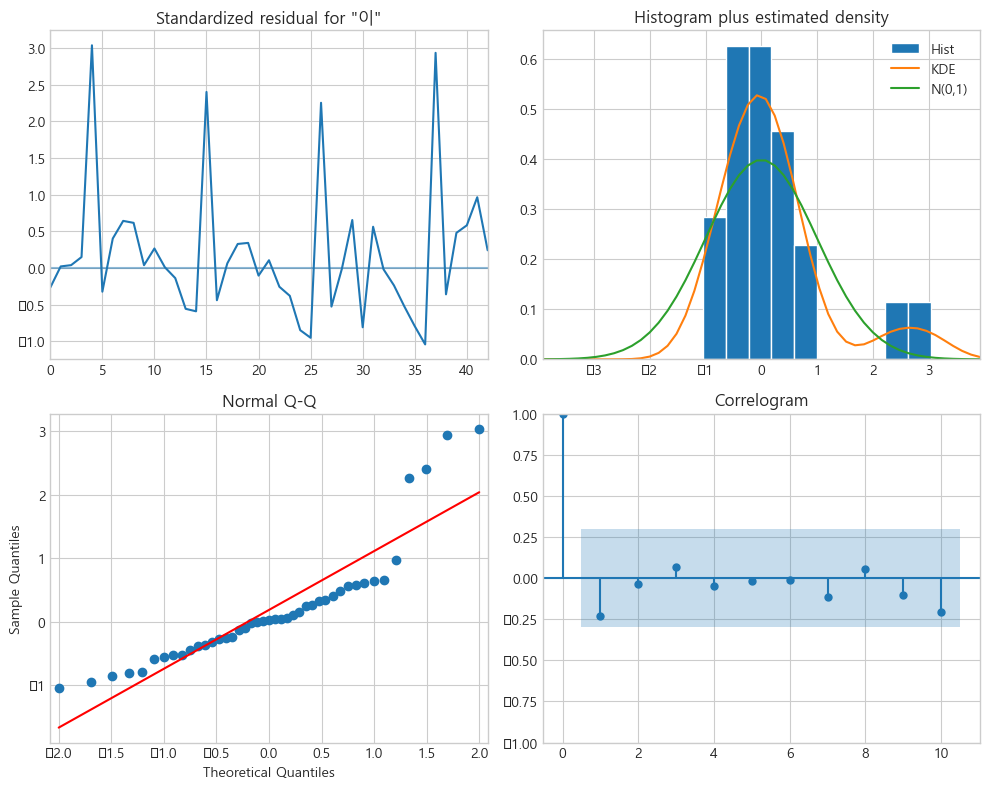

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA(1, 1, 2) model for Age Group 70대 >> AIC: 1137.2251864717741
                               SARIMAX Results                                
Dep. Variable:                  이동인구수   No. Observations:                   44
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -564.613
Date:                Tue, 15 Aug 2023   AIC                           1137.225
Time:                        14:50:42   BIC                           1144.270
Sample:                             0   HQIC                          1139.823
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4403      0.935      0.471      0.638      -1.393       2.273
ma.L1         -0.7915      1.556     -0.509      0.611      

C:\Users\82107\AppData\Local\Temp\ipykernel_25472\128104527.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


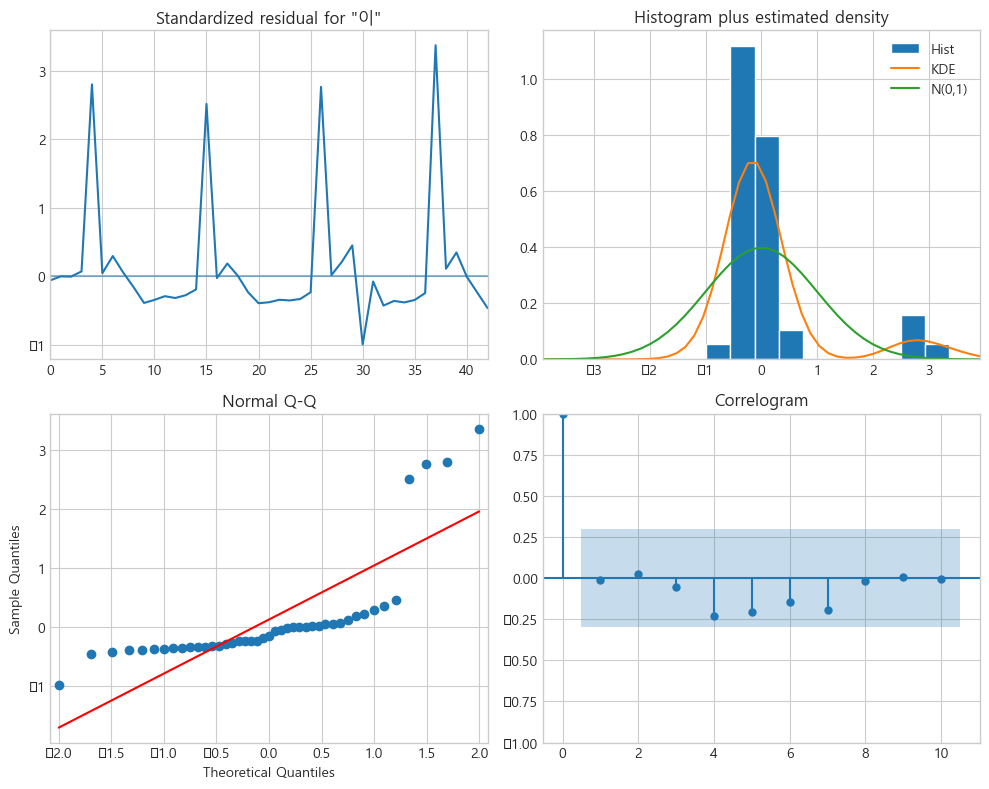

C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82107\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self.

Best ARIMA(1, 1, 1) model for Age Group 80대 >> AIC: 1069.2851454057445
                               SARIMAX Results                                
Dep. Variable:                  이동인구수   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -531.643
Date:                Tue, 15 Aug 2023   AIC                           1069.285
Time:                        14:50:46   BIC                           1074.569
Sample:                             0   HQIC                          1071.234
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4926      0.751      0.656      0.512      -0.979       1.964
ma.L1         -0.9737      0.413     -2.358      0.018      

C:\Users\82107\AppData\Local\Temp\ipykernel_25472\128104527.py:35: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


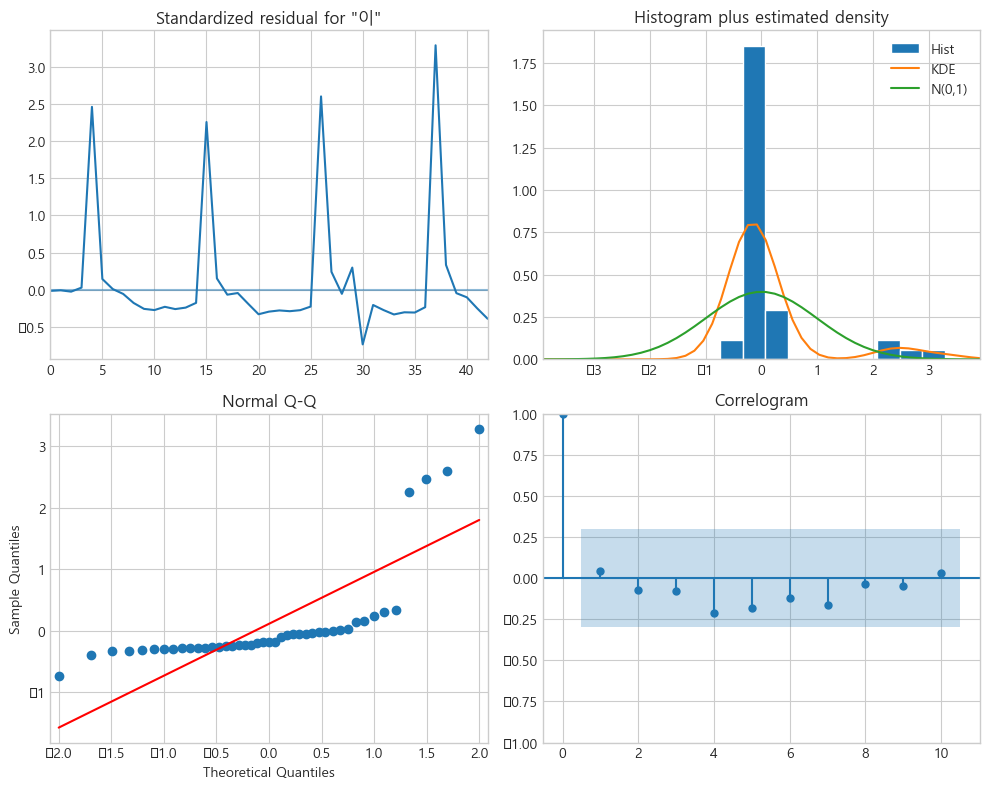

In [ ]:
p = range(1, 4)
d = range(0, 2)
q = range(1, 4)

pdq = list(itertools.product(p, d, q))

for age_group, selected_data in age_data.items():
    best_aic = np.inf
    best_order = None
    best_model = None

    for order in pdq:
        try:
            model = sm.tsa.arima.ARIMA(selected_data, order=order)
            fit_model = model.fit()

            if fit_model.aic < best_aic:
                best_aic = fit_model.aic
                best_order = order
                best_model = fit_model
        except:
            continue

    print(f"Best ARIMA{best_order} model for Age Group {age_group} >> AIC: {best_aic}")
    print(best_model.summary())

    best_model.plot_diagnostics(figsize=(10,8))
    plt.tight_layout()
    plt.show()

    if age_group == '20대':
        selected_data_20s['resid'] = best_model.resid
    elif age_group == '30대':
        selected_data_30s['resid'] = best_model.resid
    elif age_group == '40대':
        selected_data_40s['resid'] = best_model.resid
    elif age_group == '50대':
        selected_data_50s['resid'] = best_model.resid
    elif age_group == '60대':
        selected_data_60s['resid'] = best_model.resid
    elif age_group == '70대':
        selected_data_70s['resid'] = best_model.resid
    elif age_group == '80대':
        selected_data_80s['resid'] = best_model.resid

# stdresid

In [ ]:
for df in [selected_data_20s, selected_data_30s, selected_data_40s, selected_data_50s,
           selected_data_60s, selected_data_70s, selected_data_80s]:
    df['stdresid'] = (df['resid'] - np.mean(df['resid'])) / np.std(df['resid'])
    print(df.head())

                         이동인구수          resid  stdresid
대상연월       귀가시간대                                       
2022-12-01 00:00:00  445273.25  445273.250000  2.009887
           01:00:00  235751.75 -289031.488571 -1.824839
           02:00:00  164441.48   52627.664343 -0.040608
           03:00:00  116185.75  -28181.232274 -0.462613
           04:00:00   76873.03   71513.625808  0.058019
                         이동인구수          resid  stdresid
대상연월       귀가시간대                                       
2022-12-01 00:00:00  340778.68  340778.680000  1.162398
           01:00:00  192274.18 -217266.101282 -1.188017
           02:00:00  128697.24   23610.482736 -0.173475
           03:00:00   88283.07    5690.794154 -0.248950
           04:00:00   61673.57   55671.416064 -0.038438
                         이동인구수          resid  stdresid
대상연월       귀가시간대                                       
2022-12-01 00:00:00  269639.93  269639.930000  0.869186
           01:00:00  155434.05 -158247.342127 -0

In [ ]:
selected_data_20s.to_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동20대.csv")
selected_data_30s.to_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동30대.csv")
selected_data_40s.to_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동40대.csv")
selected_data_50s.to_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동50대.csv")
selected_data_60s.to_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동60대.csv")
selected_data_70s.to_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동70대.csv")
selected_data_80s.to_csv("/content/drive/MyDrive/BADA/바다톤/data/생활이동80대.csv")

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


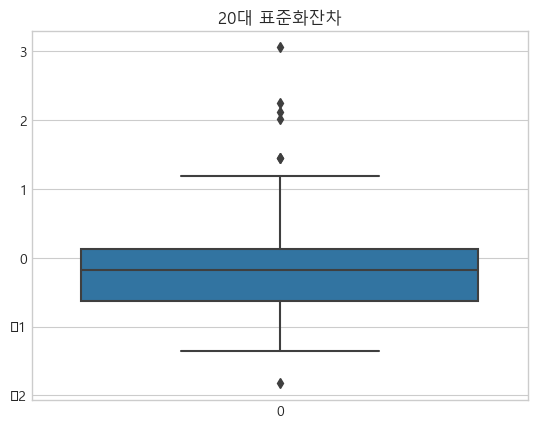

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


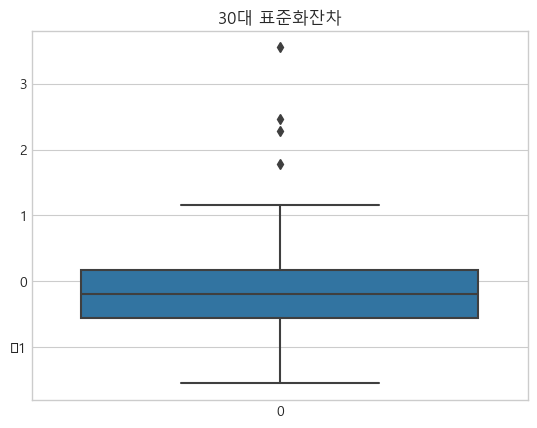

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


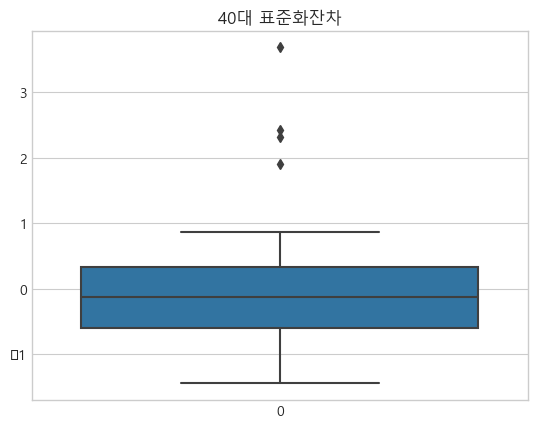

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


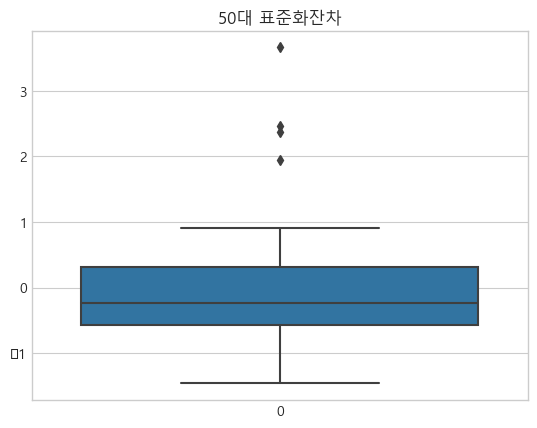

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


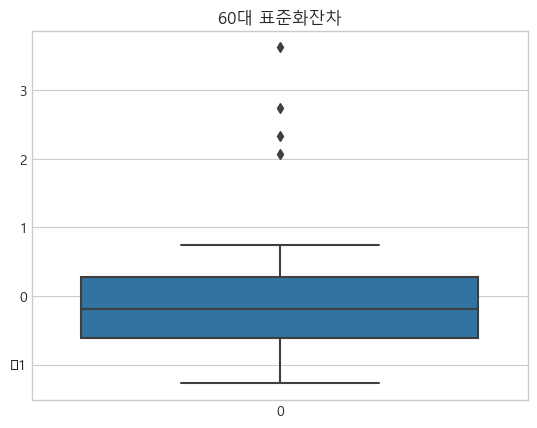

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


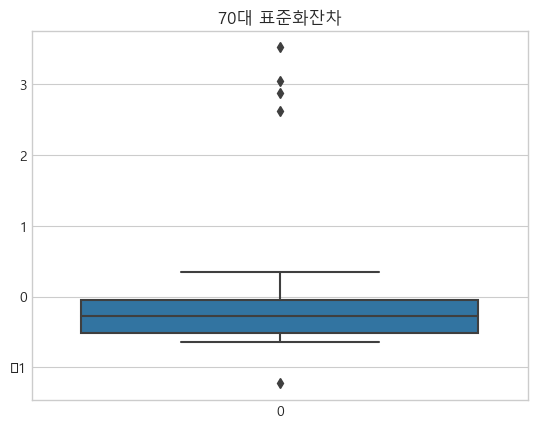

C:\Users\82107\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


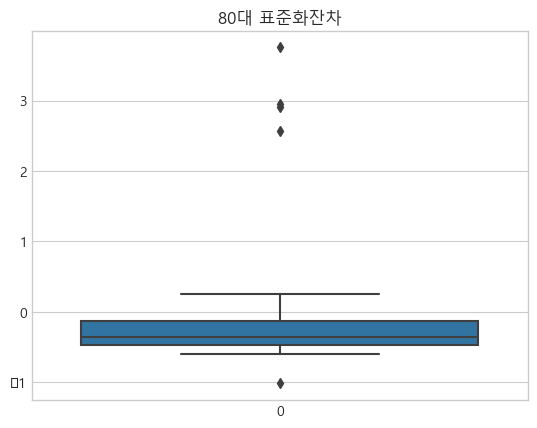

In [ ]:
for df in [selected_data_20s, selected_data_30s, selected_data_40s, selected_data_50s,
           selected_data_60s, selected_data_70s, selected_data_80s]:
    if df.equals(selected_data_20s): plt.title('20대 표준화잔차')
    elif df.equals(selected_data_30s): plt.title('30대 표준화잔차')
    elif df.equals(selected_data_40s): plt.title('40대 표준화잔차')
    elif df.equals(selected_data_50s): plt.title('50대 표준화잔차')
    elif df.equals(selected_data_60s): plt.title('60대 표준화잔차')
    elif df.equals(selected_data_70s): plt.title('70대 표준화잔차')
    elif df.equals(selected_data_80s): plt.title('80대 표준화잔차')

    sns.boxplot(df['stdresid'])
    plt.show()

# 이상치 탐지

In [ ]:
def find_outliers(df):
    outlier_df = pd.DataFrame()
    q3 = df['stdresid'].quantile(0.75)
    q1 = df['stdresid'].quantile(0.25)
    iqr = q3 - q1
    outlier_range = (df['stdresid'] < q1 - 1.5*iqr) | (df['stdresid'] > q3 + 1.5*iqr)
    outlier_df = df['stdresid'].loc[outlier_range]
    print(outlier_df)

In [ ]:
find_outliers(selected_data_20s)

대상연월        귀가시간대   
2022-12-01  00:00:00    2.009887
            01:00:00   -1.824839
            18:00:00    3.056107
2023-01-01  18:00:00    2.116297
2023-02-01  18:00:00    1.452026
2023-03-01  18:00:00    2.252381
            22:00:00    1.447345
Name: stdresid, dtype: float64


In [ ]:
find_outliers(selected_data_30s)

대상연월        귀가시간대   
2022-12-01  18:00:00    3.551253
2023-01-01  18:00:00    2.277725
2023-02-01  18:00:00    1.782624
2023-03-01  18:00:00    2.463067
Name: stdresid, dtype: float64


In [ ]:
find_outliers(selected_data_40s)

대상연월        귀가시간대   
2022-12-01  18:00:00    3.685936
2023-01-01  18:00:00    2.321186
2023-02-01  18:00:00    1.905133
2023-03-01  18:00:00    2.426573
Name: stdresid, dtype: float64


In [ ]:
find_outliers(selected_data_50s)

대상연월        귀가시간대   
2022-12-01  18:00:00    3.663503
2023-01-01  18:00:00    2.378969
2023-02-01  18:00:00    1.939551
2023-03-01  18:00:00    2.467823
Name: stdresid, dtype: float64


In [ ]:
find_outliers(selected_data_60s)

대상연월        귀가시간대   
2022-12-01  18:00:00    3.626437
2023-01-01  18:00:00    2.327320
2023-02-01  18:00:00    2.065651
2023-03-01  18:00:00    2.740997
Name: stdresid, dtype: float64


In [ ]:
find_outliers(selected_data_70s)

대상연월        귀가시간대   
2022-12-01  18:00:00    3.043125
2023-01-01  18:00:00    2.623824
2023-02-01  18:00:00    2.871469
            22:00:00   -1.225267
2023-03-01  18:00:00    3.518094
Name: stdresid, dtype: float64


In [ ]:
find_outliers(selected_data_80s)

대상연월        귀가시간대   
2022-12-01  18:00:00    2.904285
2023-01-01  18:00:00    2.562821
2023-02-01  18:00:00    2.950733
            22:00:00   -1.012953
2023-03-01  18:00:00    3.755246
Name: stdresid, dtype: float64


In [ ]:
selected_data_20s[abs(selected_data_20s['stdresid'])>=1.0]

이동인구수          resid  stdresid
대상연월       귀가시간대                                       
2022-12-01 00:00:00  445273.25  445273.250000  2.009887
           01:00:00  235751.75 -289031.488571 -1.824839
           18:00:00  722673.23  645611.890536  3.056107
           22:00:00  791476.01  287463.164968  1.185763
2023-01-01 18:00:00  694203.71  465649.397258  2.116297
2023-02-01 03:00:00   92214.71 -157904.047751 -1.140059
           18:00:00  680812.91  338449.428120  1.452026
2023-03-01 01:00:00  242239.73 -135396.314012 -1.022517
           03:00:00  104937.47 -151603.592155 -1.107156
           04:00:00   72790.25 -198854.539478 -1.353912
           18:00:00  821580.56  491707.970093  2.252381
           22:00:00  899710.20  337553.131264  1.447345

In [ ]:
selected_data_30s[abs(selected_data_30s['stdresid'])>=1.0]

이동인구수          resid  stdresid
대상연월       귀가시간대                                        
2022-12-01 00:00:00   340778.68  340778.680000  1.162398
           01:00:00   192274.18 -217266.101282 -1.188017
           18:00:00   953925.67  907950.225181  3.551253
2023-01-01 18:00:00   915599.21  605584.229668  2.277725
2023-02-01 03:00:00    71180.13 -196187.450988 -1.099236
           04:00:00    51886.17 -218284.139093 -1.192305
           18:00:00   909699.68  488035.332047  1.782624
2023-03-01 03:00:00    81306.45 -185576.484956 -1.054544
           04:00:00    59302.38 -303057.233298 -1.549358
           18:00:00  1055023.59  649588.918095  2.463067
           22:00:00   803224.47  313182.285666  1.046165

In [ ]:
selected_data_40s[abs(selected_data_40s['stdresid'])>=1.0]

이동인구수          resid  stdresid
대상연월       귀가시간대                                        
2022-12-01 18:00:00   975328.32  952035.940219  3.685936
2023-01-01 04:00:00    45842.40 -185956.158106 -1.011394
           18:00:00   917604.58  621406.649175  2.321186
2023-02-01 04:00:00    45759.97 -261463.586360 -1.323068
           18:00:00   910222.11  520612.246112  1.905133
           22:00:00   382096.44 -190047.327599 -1.028281
2023-03-01 03:00:00    64240.35 -212492.206642 -1.120927
           04:00:00    52576.83 -290569.820987 -1.443211
           18:00:00  1065981.11  646938.273650  2.426573

In [ ]:
selected_data_50s[abs(selected_data_50s['stdresid'])>=1.0]

이동인구수          resid  stdresid
대상연월       귀가시간대                                        
2022-12-01 18:00:00   925586.73  885549.274102  3.663503
2023-01-01 18:00:00   886525.03  592624.828221  2.378969
2023-02-01 03:00:00    48838.67 -183650.271722 -1.025160
           04:00:00    46240.43 -212062.145892 -1.149752
           18:00:00   876127.82  492420.382375  1.939551
2023-03-01 03:00:00    55704.01 -196003.701912 -1.079332
           04:00:00    52643.79 -282472.207834 -1.458515
           18:00:00  1007713.08  612887.173899  2.467823

In [ ]:
selected_data_60s[abs(selected_data_60s['stdresid'])>=1.0]

이동인구수          resid  stdresid
대상연월       귀가시간대                                       
2022-12-01 18:00:00  816794.12  767493.954830  3.626437
2023-01-01 18:00:00  777933.91  508266.413521  2.327320
2023-02-01 03:00:00   42481.21 -172477.205324 -1.084221
           04:00:00   54177.94 -193001.946215 -1.187080
           18:00:00  800032.07  456052.614835  2.065651
           22:00:00  210973.90 -163203.531762 -1.037746
2023-03-01 03:00:00   48850.11 -160073.679809 -1.022061
           04:00:00   63600.47 -210005.894858 -1.272295
           18:00:00  926646.29  590812.111653  2.740997

In [ ]:
selected_data_70s[abs(selected_data_70s['stdresid'])>=1.0]

이동인구수          resid  stdresid
대상연월       귀가시간대                                       
2022-12-01 18:00:00  400157.29  377867.484379  3.043125
2023-01-01 18:00:00  380564.87  328185.200950  2.623824
2023-02-01 18:00:00  416856.31  357528.286295  2.871469
           22:00:00   60952.92 -127887.076332 -1.225267
2023-03-01 18:00:00  500702.94  434145.784502  3.518094

In [ ]:
selected_data_80s[abs(selected_data_80s['stdresid'])>=1.0]

이동인구수          resid  stdresid
대상연월       귀가시간대                                       
2022-12-01 18:00:00  172291.01  164613.381166  2.904285
2023-01-01 18:00:00  166114.12  146155.378431  2.562821
2023-02-01 18:00:00  190010.27  167124.136455  2.950733
           22:00:00   23167.51  -47135.097745 -1.012953
2023-03-01 18:00:00  236976.57  210612.548223  3.755246